<a href="https://colab.research.google.com/github/bella-xia/LLM-from-scratch/blob/master/Interview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [2]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 

In [30]:
import torch, tiktoken, time, copy, statistics, textwrap
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel, modeling_utils
from datasets import load_dataset

## Quantization

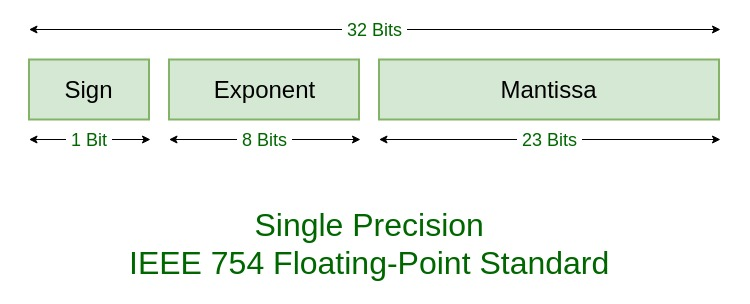 [1]

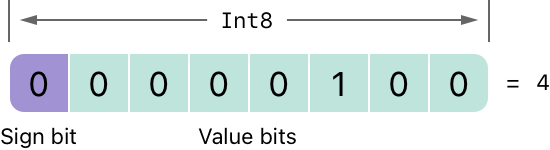 [2]

In [32]:
class DemoModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(1, 4, bias=False)
    self.fc2 = nn.Linear(4, 1, bias=False)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [33]:
demo1 = DemoModel()
demo1.fc1.weight, demo1.fc2.weight

(Parameter containing:
 tensor([[-0.0130],
         [-0.5656],
         [ 0.4519],
         [ 0.8007]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.4671, -0.1184,  0.0207,  0.2401]], requires_grad=True))

In [34]:
demo2 = torch.ao.quantization.quantize_dynamic(demo1, {nn.Linear}, dtype=torch.qint8)
demo2.fc1._packed_params._weight_bias()[0], demo2.fc2._packed_params._weight_bias()[0]

(tensor([[-0.0126],
         [-0.5652],
         [ 0.4522],
         [ 0.7976]], size=(4, 1), dtype=torch.qint8,
        quantization_scheme=torch.per_tensor_affine, scale=0.006280260626226664,
        zero_point=0),
 tensor([[ 0.4653, -0.1172,  0.0220,  0.2418]], size=(1, 4), dtype=torch.qint8,
        quantization_scheme=torch.per_tensor_affine, scale=0.0036634113639593124,
        zero_point=0))

In [35]:
input = torch.randn((4, 1))
demo1.eval()
with torch.no_grad():
  output1 = demo1(input)
print(output1)

tensor([[0.0909],
        [0.3309],
        [0.4171],
        [0.0873]])


In [36]:
demo2.eval()
with torch.no_grad():
  output2 = demo2(input)
print(output2)

tensor([[0.0933],
        [0.3319],
        [0.4187],
        [0.0913]])


The Quation involved is:

Q(x, scale, zero_point) = x / scale + zero_point

In [63]:
def demo_quantization(tensor, scale, zero_point=0):
    q_tensor = torch.clamp((tensor / scale).round() + zero_point, -128, 127).to(torch.int8)
    dq_tensor = (q_tensor.to(torch.float32) - zero_point) * scale

    print("Original tensor:", tensor)
    print("Quantized int8:", q_tensor)
    print(f"Dequantized tensor with scale {scale} and zero point {zero_point}:", dq_tensor)

In [69]:
demo_quantization(torch.tensor([0.0909]), 0.01)

Original tensor: tensor([0.0909])
Quantized int8: tensor([9], dtype=torch.int8)
Dequantized tensor with scale 0.01 and zero point 0: tensor([0.0900])


## Dummy Model Architecture

For the current experiment, I chose to implement a GPT-like Decode-only Transformer model. The model implementation specifics references the procedure in *Build a Large Language Model (From Scratch)* Textbook [3].

GPT-based Decoder-only architecture is currently one of the most popular LLM structure. Its linear stacking of Transformer blocks also provide a good, scalable architecture for performance comparison by alternating hyperparameters.

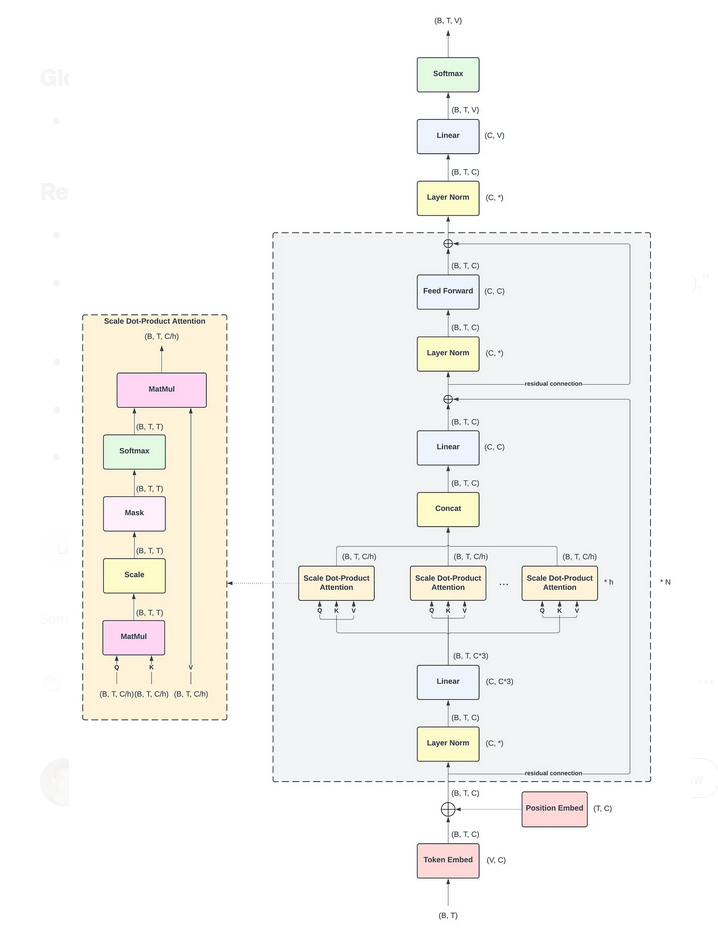

GPT2 Architecture [4]

In [2]:
class MultiHeadAttention(nn.Module):
  def __init__(self, embed_dim, out_dim, num_heads,
               drop_rate, bias):
    super().__init__()

    if (out_dim % num_heads) != 0:
      raise Exception('output dimension must be a multiple of the number of heads')

    self.out_dim = out_dim
    self.num_heads = num_heads
    self.per_head_dim = out_dim // num_heads

    self.q_proj = nn.Linear(embed_dim, out_dim, bias=bias)
    self.k_proj = nn.Linear(embed_dim, out_dim, bias=bias)
    self.v_proj = nn.Linear(embed_dim, out_dim, bias=bias)

    self.out_proj = nn.Linear(out_dim, out_dim)
    self.dropout = nn.Dropout(drop_rate)

  def forward(self, x):
    batch_size, context_len, embed_dim = x.shape

    k, q, v = self.k_proj(x), self.q_proj(x), self.v_proj(x)

    k = k.view(batch_size, context_len, self.num_heads, self.per_head_dim)
    q = q.view(batch_size, context_len, self.num_heads, self.per_head_dim)
    v = v.view(batch_size, context_len, self.num_heads, self.per_head_dim)

    attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (self.per_head_dim ** 0.5)
    attn_weights = torch.softmax(attn_scores / k.shape[-1] ** 0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)

    context_vec = torch.matmul(attn_weights, v)
    context_vec = context_vec.view(batch_size, context_len, self.out_dim)
    out = self.out_proj(context_vec)

    return out

In [3]:
class TransBlock(nn.Module):
  def __init__(self, embed_dim, num_heads, drop_rate, bias):
    super().__init__()
    self.attn_layer = MultiHeadAttention(embed_dim, embed_dim, num_heads, drop_rate, bias)
    self.ff_layer = nn.Sequential(
        nn.Linear(embed_dim, 4 * embed_dim),
        nn.ReLU(),
        nn.Linear(4 * embed_dim, embed_dim)
    )
    self.norm1 = nn.LayerNorm(embed_dim)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.dropout = nn.Dropout(drop_rate)

  def forward(self, x):
    # attention layer
    residual = x
    x = self.attn_layer(x)
    x = self.dropout(x)
    x = self.norm1(x + residual)

    # feed forward layer
    residual = x
    x = self.ff_layer(x)
    x = self.dropout(x)
    x = self.norm2(x + residual)

    return x

In [4]:
class DecoderModel(nn.Module):
  def __init__(self, vocab_size, num_heads,
               embed_dim, context_len, drop_rate,
               num_layer, bias=False):
    super().__init__()
    self.tok_embed = nn.Embedding(vocab_size, embed_dim)
    self.pos_embed = nn.Embedding(context_len, embed_dim)
    self.drop_layer = nn.Dropout(drop_rate)
    self.transformer_blocks = nn.Sequential(
        *[TransBlock(embed_dim, num_heads, drop_rate, bias) for _ in range(num_layer)]
    )
    self.out_norm = nn.LayerNorm(embed_dim)
    self.out_head = nn.Linear(embed_dim, vocab_size)

  def forward(self, x):
    device = x.device
    _, context_len = x.shape

    tok_embeds = self.tok_embed(x).to(device)
    pos_embeds = self.pos_embed(torch.arange(context_len, device=device))
    x = tok_embeds + pos_embeds
    x = self.drop_layer(x)
    x = self.transformer_blocks(x)
    x = self.out_norm(x)
    logits = self.out_head(x)

    return logits

## Inference

In [22]:
# meta configs
SEED = 42

# environment
DEVICE = torch.device('cpu')
print(f'currently working on {DEVICE}')

# model architecture (uses default gpt2 hyperparams)
VOCAB_SIZE = 50257
NUM_HEADS = 8
EMBED_DIM = 512
CONTEXT_LEN = 256
DROP_RATE = 0.1
NUM_LAYER = 12
BIAS = False

currently working on cpu



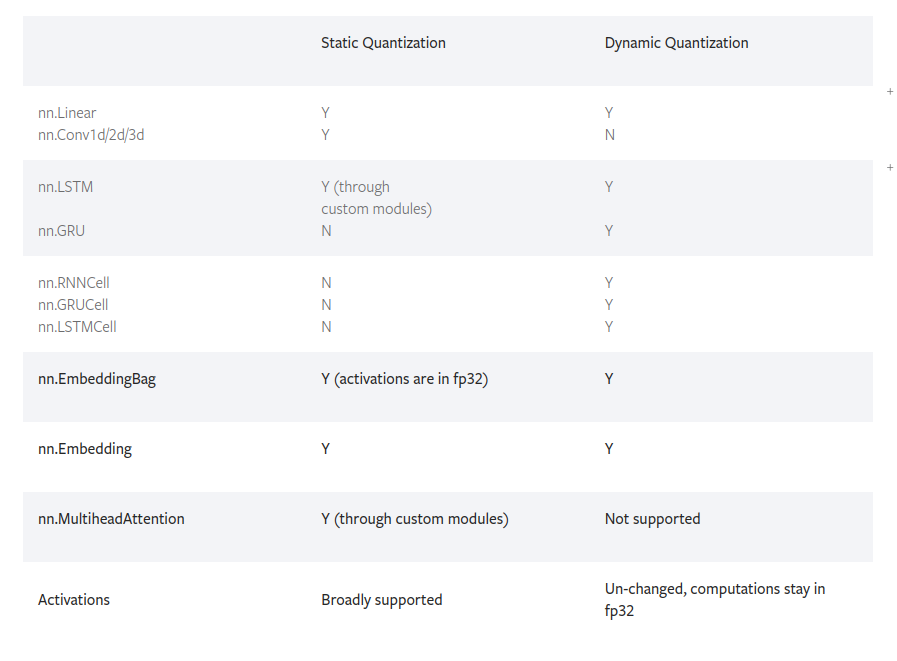



### Helper Functions

In [40]:
def generate_encoded_context(context_len):
  torch.manual_seed(SEED)
  torch.random.manual_seed(SEED)
  context = torch.randint(0, VOCAB_SIZE, (context_len,))
  return context

In [41]:
def process_comparative_scheme(spec, min_val, max_val, is_log=False):

  variables, times1, times2 = [], [], []
  for i in trange(min_val, max_val):
    variable = 2 ** i if is_log else i
    torch.manual_seed(SEED)
    torch.random.manual_seed(SEED)
    model = DecoderModel(VOCAB_SIZE,
                         variable if spec == 'num heads' else NUM_HEADS,
                         variable if spec == 'embedding dim' else EMBED_DIM,
                         variable if spec == 'context length' else CONTEXT_LEN,
                         DROP_RATE,
                         variable if spec == 'layer number' else NUM_LAYER,
                         BIAS)
    model_dq = torch.ao.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)
    model.to(DEVICE)
    model_dq.to(DEVICE)
    model.eval()
    model_dq.eval()
    idx = generate_encoded_context(variable if spec == 'context length' else CONTEXT_LEN).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
      start1 = time.time()
      model(idx)
      end1 = time.time()
      times1.append(end1 - start1)
      start2 = time.time()
      model_dq(idx)
      end2 = time.time()
      times2.append(end2 - start2)
    variables.append(variable)
  visualize_data(spec, variables, times1, times2, is_log)

In [45]:
def visualize_data(spec, variables, times1, times2, is_log):
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))
  axes[0].plot(variables, times1, label='fp32')
  axes[0].plot(variables, times2, label='int8')
  axes[0].legend()
  if is_log:
    axes[0].set_xscale('log', base=2)
  axes[0].set_xlabel(spec)
  axes[0].set_ylabel('time (s)')
  axes[0].set_title('fp32 time vs int8 time')
  axes[0].grid()

  ratios = [time1 / time2 for (time1, time2) in zip(times1, times2)]
  axes[1].plot(variables, ratios)
  if is_log:
    axes[1].set_xscale('log', base=2)
  axes[1].set_xlabel(spec)
  axes[1].set_ylabel('ratio')
  axes[1].set_title('fp32 time / int8 duration Ratio')
  axes[1].grid()

  plt.show()

### Inference Time Comparison on Dummy Model

100%|██████████| 12/12 [00:48<00:00,  4.04s/it]


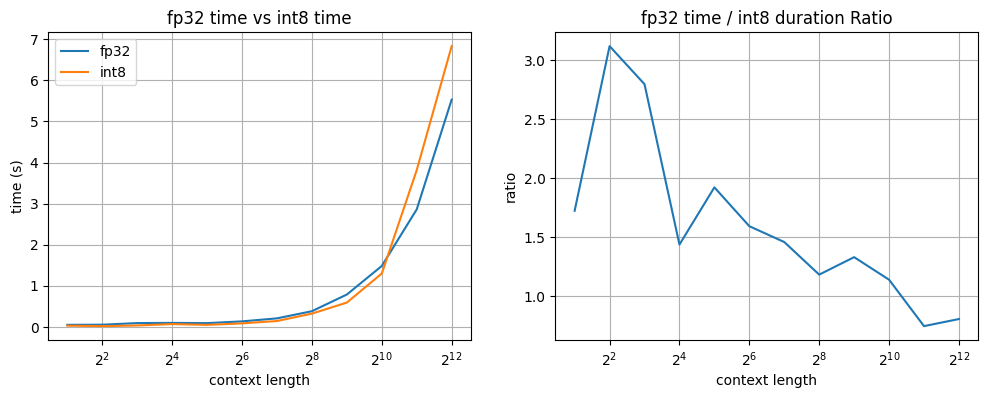

In [46]:
process_comparative_scheme('context length', 1, 13, True)

100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


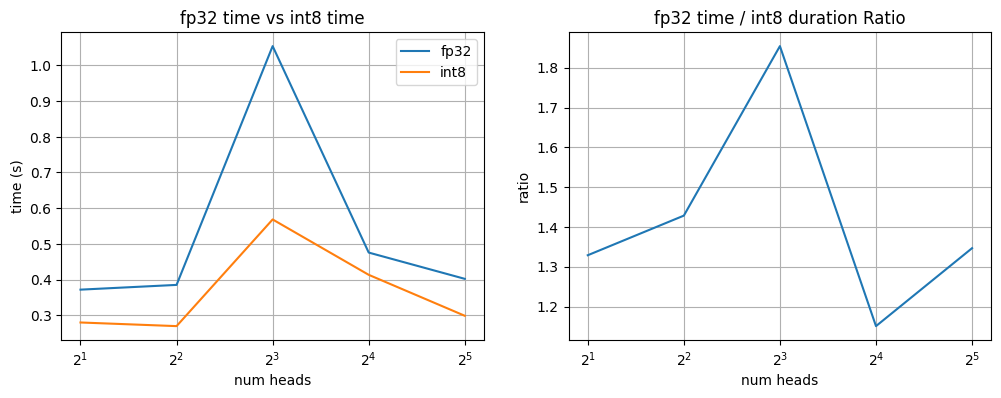

In [52]:
process_comparative_scheme('num heads', 1, 6, True)

100%|██████████| 11/11 [00:22<00:00,  2.01s/it]


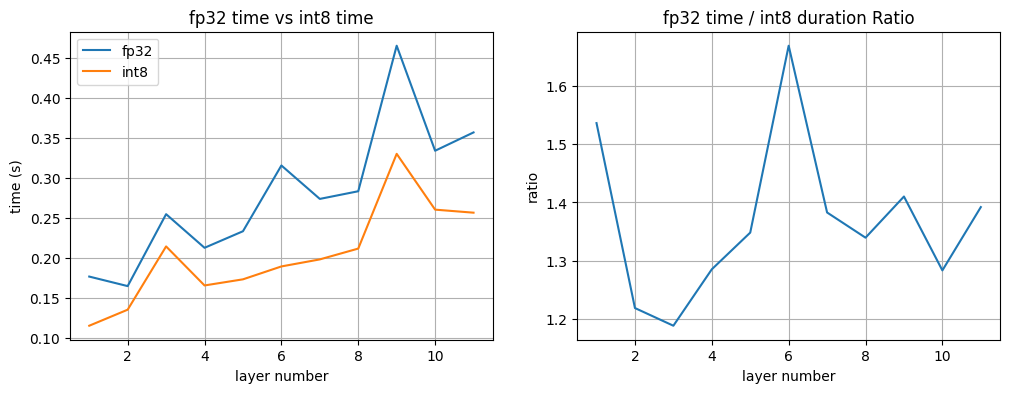

In [51]:
process_comparative_scheme('layer number', 1, 12, False)

100%|██████████| 8/8 [00:14<00:00,  1.78s/it]


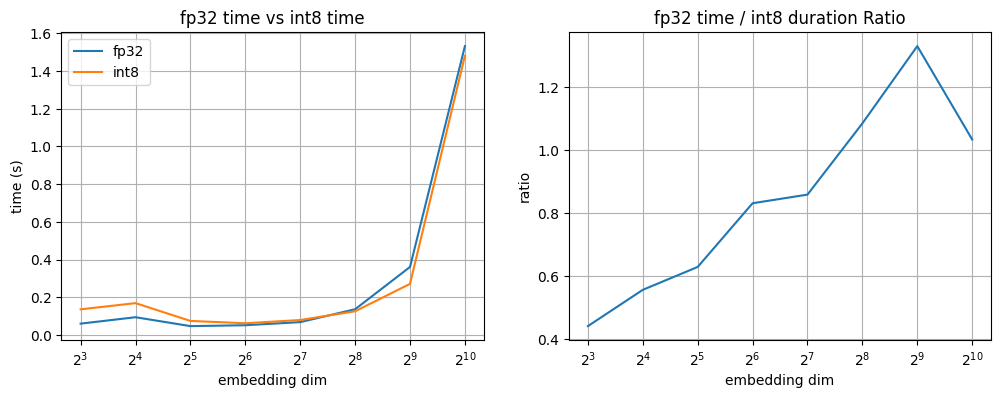

In [50]:
process_comparative_scheme('embedding dim', 3, 11, True)

## Quantization on Pre-trained LLM (GPT2)

In [17]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [18]:
gpt2_model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [52]:
def convert_conv1d_to_linear(conv1d):
  linear = nn.Linear(conv1d.weight.shape[0], conv1d.weight.shape[1])
  with torch.no_grad():
      linear.weight.copy_(conv1d.weight.T)
      linear.bias.copy_(conv1d.bias)
  return linear

In [54]:
def replace_conv1d_with_linear(module, names):
  for name, child in module.named_children():
    if isinstance(child, modeling_utils.Conv1D):
      if name in names:
        setattr(module, name, convert_conv1d_to_linear(child))
    else:
      replace_conv1d_with_linear(child, names)

### Inference Demo

In [38]:
def HF_GPT2_generator(model, starter_text, max_new_tokens=10):
    model.to(DEVICE)
    model.eval()

    input_ids = tokenizer.encode(starter_text, return_tensors='pt').to(DEVICE)
    generated = input_ids
    times = []

    with torch.no_grad():
        for _ in trange(max_new_tokens):
          start = time.time()
          outputs = model(generated)
          outputs = model(generated)
          end = time.time()
          times.append(end - start)
          logits = outputs.logits

          next_token_logits = logits[:, -1, :]
          next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

          generated = torch.cat((generated, next_token_id), dim=1)
    print('')
    print(f'average inference time: {statistics.mean(times):.8f}s, standard deviation: {statistics.stdev(times):.8f}s')
    generated_text = tokenizer.decode(generated[0], skip_special_tokens=True)
    return generated_text

In [39]:
text = "As Gregor Samsa awoke one morning from uneasy dreams he found himself "

In [40]:
ret = HF_GPT2_generator(gpt2_model, text, max_new_tokens=20)
print('\ngenerated text:')
print(textwrap.fill(ret, width=80))

100%|██████████| 20/20 [00:02<00:00,  7.67it/s]


average inference time: 0.12916425s, standard deviation: 0.01657788s

generated text:
As Gregor Samsa awoke one morning from uneasy dreams he found himself  in the
middle of a battle with a demon. He was in the middle of a battle with


In [48]:
# only lm header
gpt2_model_header_dq = torch.ao.quantization.quantize_dynamic(gpt2_model, {nn.Linear}, dtype=torch.qint8)
print(gpt2_model_header_dq)
ret = HF_GPT2_generator(gpt2_model_header_dq, text, max_new_tokens=20)
print('\ngenerated text:')
print(textwrap.fill(ret, width=80))
del gpt2_model_header_dq

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): DynamicQuantizedLinear(in_features=768, out_features=50257, dtype=torch.qint8, qscheme=torch.per_tensor_affine)

100%|██████████| 20/20 [00:01<00:00, 10.46it/s]


average inference time: 0.09504387s, standard deviation: 0.00919006s

generated text:
As Gregor Samsa awoke one morning from uneasy dreams he found himself iced and
and, among Tibetan slaves laden underground lending liquor brewed perilingly
pleasantly afterwards. Watching Lent


In [55]:
# feed-forward + attention layer + lm header
gpt2_model_proj_dq = copy.deepcopy(gpt2_model)
replace_conv1d_with_linear(gpt2_model_proj_dq, ['c_proj'])
gpt2_model_proj_dq = torch.ao.quantization.quantize_dynamic(gpt2_model_proj_dq, {nn.Linear}, dtype=torch.qint8)
print(gpt2_model_proj_dq)
ret = HF_GPT2_generator(gpt2_model_proj_dq, text, max_new_tokens=20)
print('\ngenerated text:')
print(textwrap.fill(ret, width=80))
del gpt2_model_proj_dq

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): DynamicQuantizedLinear(in_features=3072, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNor

100%|██████████| 20/20 [00:01<00:00, 11.22it/s]


average inference time: 0.08843330s, standard deviation: 0.01978535s

generated text:
As Gregor Samsa awoke one morning from uneasy dreams he found himself piralled,
the "pudent and the "a, and, the, the, the


In [56]:
# attention layer + lm header
gpt2_model_attn_dq = copy.deepcopy(gpt2_model)
replace_conv1d_with_linear(gpt2_model_attn_dq, {'c_attn'})
gpt2_model_attn_dq = torch.ao.quantization.quantize_dynamic(gpt2_model_attn_dq, {nn.Linear}, dtype=torch.qint8)
print(gpt2_model_attn_dq)
ret = HF_GPT2_generator(gpt2_model_attn_dq, text, max_new_tokens=20)
print('\ngenerated text:')
print(textwrap.fill(ret, width=80))
del gpt2_model_attn_dq

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): DynamicQuantizedLinear(in_features=768, out_features=2304, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): DynamicQuantizedLinear(i

100%|██████████| 20/20 [00:01<00:00, 11.22it/s]



average inference time: 0.08849084s, standard deviation: 0.00896161s

generated text:
As Gregor Samsa awoke one morning from uneasy dreams he found himself iced in
the one, the "pigliterest, the "futernight-b


In [57]:
gpt2_model_dq = copy.deepcopy(gpt2_model)
replace_conv1d_with_linear(gpt2_model_dq, {'c_attn', 'c_fc', 'c_proj'})
gpt2_model_dq = torch.ao.quantization.quantize_dynamic(gpt2_model_dq, {nn.Linear}, dtype=torch.qint8)
print(gpt2_model_dq)
ret = HF_GPT2_generator(gpt2_model_dq, text, max_new_tokens=20)
print('\ngenerated text:')
print(textwrap.fill(ret, width=80))

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): DynamicQuantizedLinear(in_features=768, out_features=2304, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
          (c_proj): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): DynamicQuantizedLinear(in_features=768, out_features=3072, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
          (c_proj): DynamicQuantizedLinear(in_features=3072, out_features=768, dtype=torc

100%|██████████| 20/20 [00:01<00:00, 17.30it/s]


average inference time: 0.05726343s, standard deviation: 0.01772987s

generated text:
As Gregor Samsa awoke one morning from uneasy dreams he found himself uk, and
challengcery challengallery condemglomerallery condemventures condemciplallery
condemciplenza condemestate


## Citations
[1] "IEEE Standard 754 Floating Point Numbers" https://www.geeksforgeeks.org/ieee-standard-754-floating-point-numbers/

[2] "The Swift Programming Language: Advanced Operators" https://docs.swift.org/swift-book/documentation/the-swift-programming-language/advancedoperators/

[3] Raschka, Sebastian. *Build a Large Language Model (From Scratch)*. Manning Publisher: 2014.

[4] "GPT-2 Detailed Model Architecture" https://medium.com/@hsinhungw/gpt-2-detailed-model-architecture-6b1aad33d16b